In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from matplotlib import font_manager

font_dirs = ["/home/hblee/.conda/envs/jax_main/fonts"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams["mathtext.fontset"] = 'cm'

import tskit
import msprime

[[1 0 0 0 0]
 [1 1 1 0 1]]


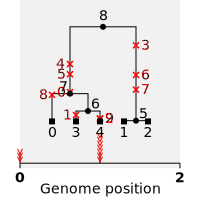

In [2]:
# test
ts = msprime.sim_ancestry(5, 
                          sequence_length=2, 
                          random_seed=1234, 
                          ploidy=1)
mts = msprime.sim_mutations(ts,
                           rate=1,
                           model=msprime.BinaryMutationModel(),
                           random_seed=1234)
print(mts.genotype_matrix(samples=mts.samples()))
mts.draw_svg()

In [3]:
def confusion_matrix(x1, x2):
    bool1 = (x1 == 0)
    bool2 = (x2 == 0)
    c00 = (bool1 & bool2).sum()
    c10 = (~bool1 & bool2).sum()
    c01 = (bool1 & ~bool2).sum()
    c11 = (~bool1 & ~bool2).sum()
    return np.array([c00, c10, c01, c11])

In [4]:
def get_frequencies(
    num_sim_tree: int,
    num_sim_mutation: int,
    num_sequences: int,
    mutation_rate: float,
) -> np.ndarray:
    mutation_model = msprime.BinaryMutationModel()
    frequencies = np.zeros((num_sim_tree, num_sim_mutation, 4))
    for i in range(num_sim_tree):
        ts = msprime.sim_ancestry(num_sequences,
                                  sequence_length=2,
                                  recombination_rate=0,
                                  ploidy=1)
        for j in range(num_sim_mutation):
            mts = msprime.sim_mutations(ts,
                                        rate=mutation_rate,
                                        model=mutation_model)
            root = np.random.binomial(n=1, p=.5)
            genotype = mts.genotype_matrix(samples=mts.samples())
            genotype = 1 - genotype if root == 1 else genotype
            if mts.num_sites == 0:
                frequencies[i,j,:] = confusion_matrix(
                    np.full(num_sequences, root), np.full(num_sequences, root)
                )
            elif mts.num_sites == 1:
                frequencies[i,j,:] = confusion_matrix(
                    genotype[0], np.full(num_sequences, root)
                )
            else:
                frequencies[i,j,:] = confusion_matrix(
                    genotype[0], genotype[1]
                )
    return frequencies / num_sequences

In [5]:
num_sim_tree, num_sim_mutation = 100, 20
num_sequences, mutation_rate = 100, 0.1
frequencies = get_frequencies(
    num_sim_tree = num_sim_tree,
    num_sim_mutation = num_sim_mutation,
    num_sequences = num_sequences,
    mutation_rate = mutation_rate
).reshape(num_sim_tree, num_sim_mutation, 2, 2).sum(axis=3)[:,:,0]
frequencies.mean(axis=1).mean()

0.49613499999999994

In [6]:
frequencies = get_frequencies(
        num_sim_tree = num_sim_tree,
        num_sim_mutation = num_sim_mutation,
        num_sequences = num_sequences,
        mutation_rate = mutation_rate
    )
frequencies.reshape(num_sim_tree, num_sim_mutation, 2, 2).sum(axis=3)[:,:,0].mean(axis=1)

array([0.51  , 0.5245, 0.525 , 0.5025, 0.5515, 0.4075, 0.5695, 0.6565,
       0.611 , 0.4565, 0.478 , 0.548 , 0.413 , 0.586 , 0.432 , 0.5515,
       0.6275, 0.674 , 0.5005, 0.4835, 0.4205, 0.4645, 0.5215, 0.566 ,
       0.538 , 0.437 , 0.575 , 0.5115, 0.4895, 0.454 , 0.578 , 0.641 ,
       0.4345, 0.537 , 0.4725, 0.4265, 0.3715, 0.426 , 0.4275, 0.4125,
       0.5695, 0.712 , 0.421 , 0.5455, 0.509 , 0.457 , 0.5015, 0.5225,
       0.4155, 0.628 , 0.572 , 0.387 , 0.467 , 0.536 , 0.4835, 0.5395,
       0.345 , 0.326 , 0.507 , 0.4795, 0.424 , 0.571 , 0.644 , 0.4395,
       0.463 , 0.6455, 0.348 , 0.4395, 0.597 , 0.6185, 0.6075, 0.374 ,
       0.3975, 0.444 , 0.403 , 0.6505, 0.408 , 0.419 , 0.6095, 0.388 ,
       0.5015, 0.4475, 0.648 , 0.5445, 0.318 , 0.3875, 0.4735, 0.465 ,
       0.4715, 0.429 , 0.5015, 0.403 , 0.6165, 0.5275, 0.464 , 0.471 ,
       0.6075, 0.459 , 0.6665, 0.5985])

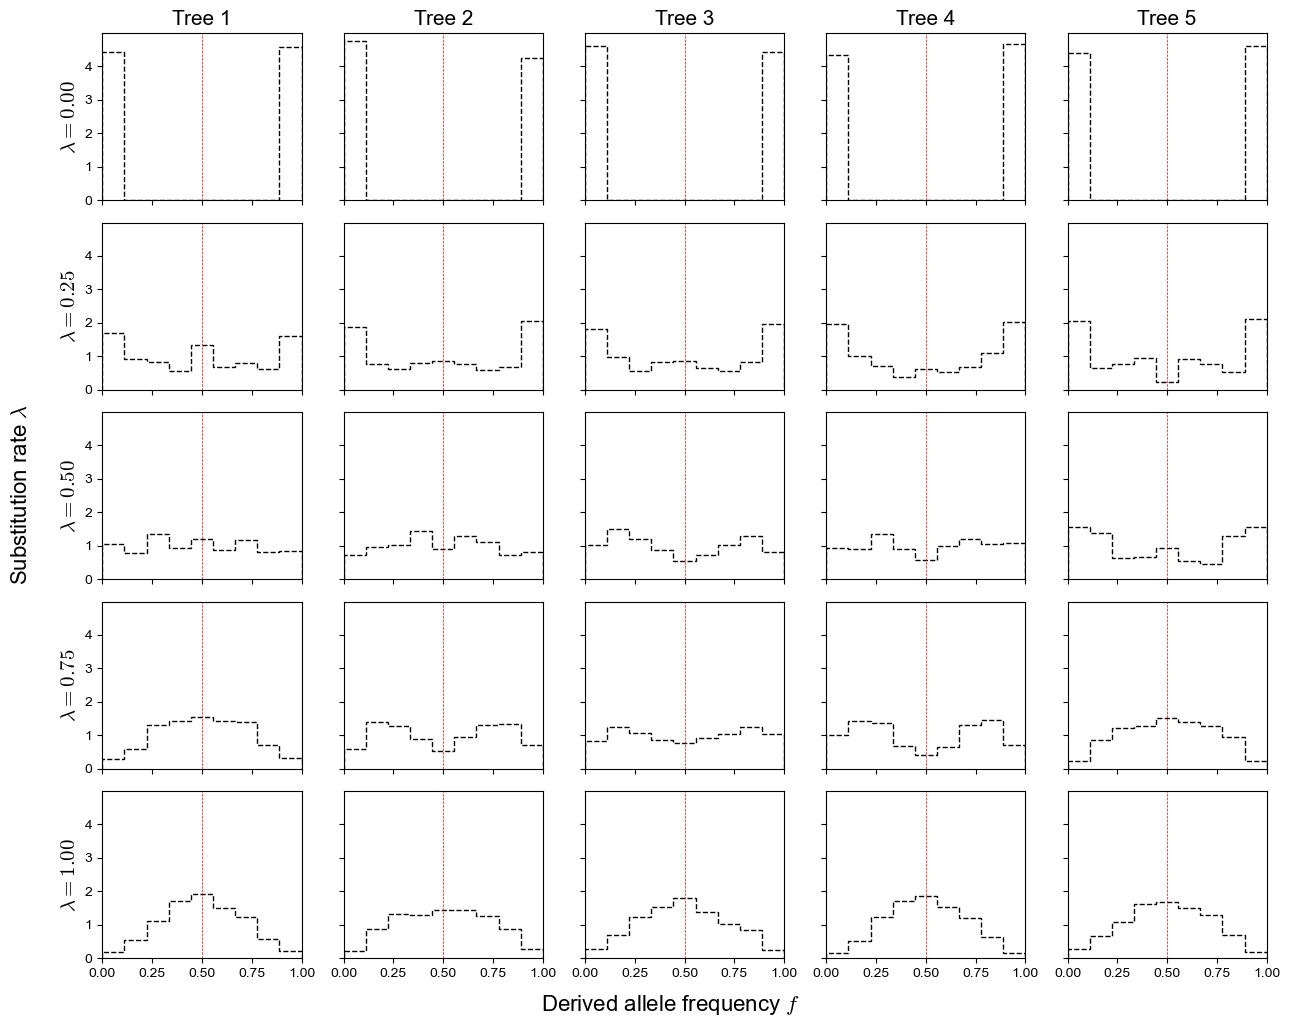

In [8]:
rates = np.linspace(0, 1, 5)
nrow, ncol = rates.size, 5
fig, ax = plt.subplots(nrow, ncol, 
                       figsize=np.array([2.5*ncol, 2*nrow]),
                       sharex=True, sharey=True)

num_sim_tree, num_sim_mutation = ncol, 1000
num_sequences = 1000
for i, rate in enumerate(rates):
    mutation_rate = rate
    frequencies = get_frequencies(
        num_sim_tree = num_sim_tree,
        num_sim_mutation = num_sim_mutation,
        num_sequences = num_sequences,
        mutation_rate = mutation_rate
    ).reshape(num_sim_tree, num_sim_mutation, 2, 2).sum(axis=3)[:,:,0]
    for j in range(ncol):
        ax[i,j].hist(frequencies[j], bins=np.linspace(0,1,10),
                         density=True, edgecolor='black', histtype=u'step', ls='--')
        ax[i,j].set_xlim([0,1])
        ax[i,j].axvline(0.5, color='red', lw=0.5, label=r'$f=0.5$', ls='--')
        if i == 0:
            ax[i,j].set_title('Tree %d' % (j+1), fontsize=15)
        if j == 0:
            ax[i,j].set_ylabel(r'$\lambda=%.2f$' % rate, fontsize=15)

        prob = np.mean(np.abs(frequencies[j]-0.5) < 0.2)

fig.text(-0.02, 0.5, r'Substitution rate $\lambda$', fontsize=16, rotation=90,
         ha='center', va='center')
fig.text(0.5, -0.01, r'Derived allele frequency $f$', fontsize=16, ha='center', va='center')
plt.tight_layout()
plt.savefig('figure4.eps', bbox_inches='tight')
plt.show()